In [152]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
import os
print(os.listdir('.'))
train = pd.read_csv('input2/train.csv')
test = pd.read_csv('input2/test.csv')

all_data = pd.concat((train, test), axis=0, sort=False).reset_index(drop=True)

['.ipynb_checkpoints', 'Analise_Variavel_Alley.ipynb', 'Analise_Variavel_MiscFeature.ipynb', 'Analise_Variavel_Qualidade_Piscina.ipynb', 'Fast_through_variables_categorical.ipynb', 'Fast_through_variables_modelagem.ipynb', 'Fast_through_variables_numerical.ipynb', 'HousePriceV012-20200414.ipynb', 'input2', 'submissionv020-xgbbost.csv']


In [153]:
# Preencher não informados com vazios.
train['FireplaceQu'] = train['FireplaceQu'].fillna('NA')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NA')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NA')

# Criando novas variaveis
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NA')
all_data['FireplaceQu'] = all_data['FireplaceQu'].apply(lambda x:
                                                        5 if x in ['Ex'] else
                                                        4 if x in ['Gd'] else
                                                        3 if x in ['TA'] else
                                                        2 if x in ['Fa'] else
                                                        1 if x in ['Po'] 
                                                        else 0)
all_data['FireplaceQuFireplaces'] = all_data['FireplaceQu'] * all_data['Fireplaces'] 



# Lotfrontage
dbfilter = all_data[['LotArea','LotFrontage']].copy()
X = dbfilter.iloc[:, [0,0]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
all_data['ClusterLotArea'] = y_hc
all_data["LotFrontage"] = all_data.groupby("ClusterLotArea")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

all_data.loc[all_data.index==2126, "GarageFinish"]='Unf'
all_data.loc[all_data.index==2126, "GarageQual"]='Po'
all_data.loc[all_data.index==2126, "GarageYrBlt"]=all_data[all_data["GarageQual"]=='Po']['GarageYrBlt'].min()
all_data.loc[all_data.index==2126, "GarageCond"]='Po'
all_data.loc[all_data.index==2576, "GarageCars"]=0
all_data.loc[all_data.index==2576, "GarageArea"]=0
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('NA')
all_data['GarageQual'] = all_data['GarageQual'].fillna('NA')
all_data['GarageCond'] = all_data['GarageCond'].fillna('NA')
all_data['GarageType'] = all_data['GarageType'].fillna('NA')
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

all_data.loc[all_data.index.isin([2348,1487,948]), "BsmtExposure"]='Av'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtCond'].isnull()), "BsmtCond"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtQual'].isnull()), "BsmtQual"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtFinType2'].isnull()), "BsmtFinType2"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtFinType1'].isnull()), "BsmtFinType1"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtExposure'].isnull()), "BsmtExposure"] = 'NA'
all_data.loc[all_data.index==2120,['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFullBath', 'BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']] = all_data[(all_data.index==1856)][['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']].values
all_data.loc[(all_data.index==2040), "BsmtCond"]='Gd'
all_data.loc[(all_data.index==2185), "BsmtCond"]='TA'
all_data.loc[(all_data.index==2524), "BsmtCond"]='TA'
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('Unf')
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data.loc[(all_data.index.isin([2216,2904])), "MSZoning"]='RL'
all_data.loc[(all_data.index.isin([1915,2250])), "MSZoning"]='RM'
all_data['Utilities'] = all_data['Utilities'].fillna('ELO')
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('Other')
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('Other')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

train = train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','Street','Utilities'], 1).copy()
test = test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','Street','Utilities'], 1).copy()
all_data = all_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','ClusterLotArea','Street','Utilities'], 1).copy()

# deletado por fraco porder de separação 
all_data = all_data.drop(['LandSlope','Condition1','Condition2','RoofStyle','RoofMatl',
                          'RoofMatl','BsmtFinType2','Heating', 'Electrical','Functional', 'GarageCond', 
                          'SaleType','SaleCondition'], 1).copy()

In [154]:
# Ajustes de classificações
all_data.loc[(all_data['MSZoning']=='RM'), "MSZoning"] = 'RH'

all_data.loc[(all_data['LotShape']=='IR3'), "LotShape"] = 'IR2'

all_data.loc[(all_data['LandContour']=='Low'), "LandContour"] = 'HLS'

all_data.loc[(all_data['LotConfig']=='FR2'), "LotConfig"] = 'Corner'
all_data.loc[(all_data['LotConfig']=='FR3'), "LotConfig"] = 'CulDSac'

# SEPARACAO DOS BAIRROS
dbfilter = all_data[(~all_data['Neighborhood'].isnull()) & (all_data['SalePrice'] > 0)][['Neighborhood','SalePrice']].copy()
dbfilter['media']=all_data['Neighborhood'].map(dbfilter.groupby(["Neighborhood"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Neighborhood')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Neighborhood'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Neighborhood'].max().copy()
all_data['Neighborhood'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

"""
dbfilter2 = train.groupby('Neighborhood')['SalePrice'].median().to_frame(name = 'MediaBairro').reset_index().sort_values('MediaBairro',ascending=True).copy()
X = dbfilter2.iloc[:, [1,1]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['ClusterBairro'] = y_hc
#grafico['ClusterBairroGrupo'] = all_data.groupby("ClusterBairro")["LotFrontage"].transform(
#    lambda x: x.fillna(x.median()))
dbfilter2['ClusterValue'] = dbfilter2['ClusterBairro'].map(dbfilter2.groupby('ClusterBairro')['MediaBairro'].max()).copy()
dbfilter3 = dbfilter2[(dbfilter2['MediaBairro']==dbfilter2['ClusterValue'])][['ClusterBairro', 'Neighborhood']]
dbfilter3 = dbfilter3.set_index('ClusterBairro').copy()
dbfilter4 = dbfilter2.set_index('Neighborhood').copy()
mean_encode = dbfilter4['ClusterBairro']
all_data['ClusterBairro'] = all_data['Neighborhood'].map(mean_encode)
all_data['Neighborhood'] = all_data['ClusterBairro'].map(dbfilter3['Neighborhood'])
all_data = all_data.drop(['ClusterBairro'], 1).copy()
"""

all_data.loc[(all_data['BldgType']=='2fmCon'), "BldgType"] = 'Duplex'
all_data.loc[(all_data['BldgType']=='Twnhs'), "BldgType"] = 'Duplex'
all_data.loc[(all_data['BldgType']=='TwnhsE'), "BldgType"] = '1Fam'

#SEPARACAO DOS HouseStyle
dbfilter = all_data[(~all_data['HouseStyle'].isnull()) & (all_data['SalePrice'] > 0)][['HouseStyle','SalePrice']].copy()
dbfilter['media']=all_data['HouseStyle'].map(dbfilter.groupby(["HouseStyle"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('HouseStyle')['Cluster'].max().copy()
all_data['Cluster'] = all_data['HouseStyle'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['HouseStyle'].max().copy()
all_data['HouseStyle'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Exterior1st
dbfilter = all_data[(~all_data['Exterior1st'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior1st','SalePrice']].copy()
dbfilter['media']=all_data['Exterior1st'].map(dbfilter.groupby(["Exterior1st"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior1st')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior1st'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior1st'].max().copy()
all_data['Exterior1st'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()
"""
dbfilter2 = train.groupby('Exterior1st')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
X = dbfilter2.iloc[:, [1,1]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
dbfilter3 = dbfilter2[['Cluster','Exterior1st']].copy().set_index('Exterior1st')
mean_encode = dbfilter3['Cluster']
all_data['Cluster'] = all_data['Exterior1st'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior1st'].max().copy()
all_data['Exterior1st'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()
"""
# separacao Exterior2nd
dbfilter = all_data[(~all_data['Exterior2nd'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior2nd','SalePrice']].copy()
dbfilter['media']=all_data['Exterior2nd'].map(dbfilter.groupby(["Exterior2nd"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior2nd')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior2nd'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior2nd'].max().copy()
all_data['Exterior2nd'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['MasVnrType']=='BrkCmn'), "MasVnrType"] = 'None'

# separacao Exterior2nd
dbfilter = all_data[(~all_data['ExterCond'].isnull()) & (all_data['SalePrice'] > 0)][['ExterCond','SalePrice']].copy()
dbfilter['media']=all_data['ExterCond'].map(dbfilter.groupby(["ExterCond"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('ExterCond')['Cluster'].max().copy()
all_data['Cluster'] = all_data['ExterCond'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['ExterCond'].max().copy()
all_data['ExterCond'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Foundation
dbfilter = all_data[(~all_data['Foundation'].isnull()) & (all_data['SalePrice'] > 0)][['Foundation','SalePrice']].copy()
dbfilter['media']=all_data['Foundation'].map(dbfilter.groupby(["Foundation"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Foundation')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Foundation'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Foundation'].max().copy()
all_data['Foundation'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['BsmtQual']=='BrkCmn'), "BsmtQual"] = 'None'
all_data.loc[(all_data['BsmtExposure']=='Mn'), "BsmtExposure"] = 'Av'

# separacao BsmtFinType1
dbfilter = all_data[(~all_data['BsmtFinType1'].isnull()) & (all_data['SalePrice'] > 0)][['BsmtFinType1','SalePrice']].copy()
dbfilter['media']=all_data['BsmtFinType1'].map(dbfilter.groupby(["BsmtFinType1"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('BsmtFinType1')['Cluster'].max().copy()
all_data['Cluster'] = all_data['BsmtFinType1'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['BsmtFinType1'].max().copy()
all_data['BsmtFinType1'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao HeatingQC
dbfilter = all_data[(~all_data['HeatingQC'].isnull()) & (all_data['SalePrice'] > 0)][['HeatingQC','SalePrice']].copy()
dbfilter['media']=all_data['HeatingQC'].map(dbfilter.groupby(["HeatingQC"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('HeatingQC')['Cluster'].max().copy()
all_data['Cluster'] = all_data['HeatingQC'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['HeatingQC'].max().copy()
all_data['HeatingQC'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao GarageType
dbfilter = all_data[(~all_data['GarageType'].isnull()) & (all_data['SalePrice'] > 0)][['GarageType','SalePrice']].copy()
dbfilter['media']=all_data['GarageType'].map(dbfilter.groupby(["GarageType"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('GarageType')['Cluster'].max().copy()
all_data['Cluster'] = all_data['GarageType'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['GarageType'].max().copy()
all_data['GarageType'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao GarageQual
dbfilter = all_data[(~all_data['GarageQual'].isnull()) & (all_data['SalePrice'] > 0)][['GarageQual','SalePrice']].copy()
dbfilter['media']=all_data['GarageQual'].map(dbfilter.groupby(["GarageQual"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('GarageQual')['Cluster'].max().copy()
all_data['Cluster'] = all_data['GarageQual'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['GarageQual'].max().copy()
all_data['GarageQual'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['PavedDrive']=='P'), "PavedDrive"] = 'N'

In [162]:
dbfilter = all_data[(~all_data['GarageType'].isnull()) & (all_data['SalePrice'] > 0)][['GarageType','SalePrice']] 
dbfilter

,GarageType,SalePrice
0,Attchd,208500.0
1,Attchd,181500.0
2,Attchd,223500.0
3,Detchd,140000.0
4,Attchd,250000.0
...,...,...
1455,Attchd,175000.0
1456,Attchd,210000.0
1457,Attchd,266500.0
1458,Attchd,142125.0


In [163]:
dbfilter['GarageType'].unique()

dbfilter.groupby(["GarageType"])["SalePrice"].count()

GarageType
Attchd     870
BuiltIn     88
Detchd     412
NA          90
Name: SalePrice, dtype: int64

In [135]:
grouped_anova = dbfilter.groupby(["PavedDrive"])
anova_results = stats.f_oneway(grouped_anova.get_group("Ex")['SalePrice'],grouped_anova.get_group("Gd")['SalePrice'])
anova_results

KeyError: 'Ex'

In [157]:
mc = MultiComparison(dbfilter['SalePrice'], dbfilter['MSZoning'])
result = mc.tukeyhsd()
 
print(result.summary())
print(mc.groupsunique)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
 group1 group2   meandiff  p-adj     lower       upper    reject
----------------------------------------------------------------
C (all)     FV 139486.0615  0.001  73849.2883 205122.8348   True
C (all)     RH  52147.2265  0.138  -10249.277   114543.73  False
C (all)     RL 116476.9948  0.001  55107.6174 177846.3722   True
     FV     RH  -87338.835  0.001 -114431.034 -60246.6361   True
     FV     RL -23009.0668 0.0772 -47643.6782   1625.5447  False
     RH     RL  64329.7683  0.001  50473.2996   78186.237   True
----------------------------------------------------------------
['C (all)' 'FV' 'RH' 'RL']


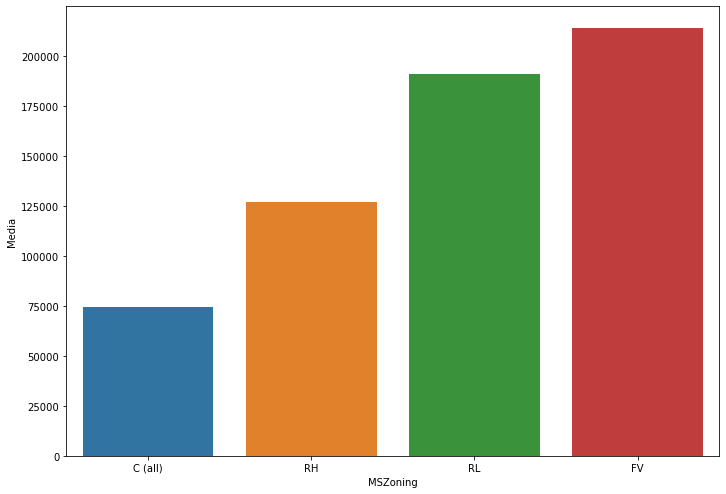

In [159]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
grafico = dbfilter.groupby('MSZoning')['SalePrice'].mean().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True) 
grafico
sns.barplot(ax=ax,data=grafico,x='MSZoning', y='Media')

In [588]:
dbfilter

,Exterior2nd,SalePrice,media
0,VinylSd,208500.0,216024.566667
1,Wd Shng,181500.0,156430.472093
2,VinylSd,223500.0,216024.566667
3,Wd Shng,140000.0,156430.472093
4,VinylSd,250000.0,216024.566667
...,...,...,...
1455,VinylSd,175000.0,216024.566667
1456,Wd Shng,210000.0,156430.472093
1457,VinylSd,266500.0,216024.566667
1458,Wd Shng,142125.0,156430.472093


In [87]:
all_data[(all_data['PoolQC'] == 'Ex')][['PoolQC', 'SalePrice']]

,PoolQC,SalePrice
197,Ex,235000.0
1182,Ex,745000.0
1974,Ex,NaN
2573,Ex,NaN


In [170]:
dbfilter[(dbfilter['SalePrice']>0)].corr()

,FireplaceQu,SalePrice,Fireplaces,FireplaceQuFireplaces
FireplaceQu,1.000000,0.520438,0.863241,0.903035
SalePrice,0.520438,1.000000,0.466929,0.510043
Fireplaces,0.863241,0.466929,1.000000,0.961538
FireplaceQuFireplaces,0.903035,0.510043,0.961538,1.000000


array([[   65.,  8450.],
       [   80.,  9600.],
       [   68., 11250.],
       ...,
       [   66.,  9042.],
       [   68.,  9717.],
       [   75.,  9937.]])

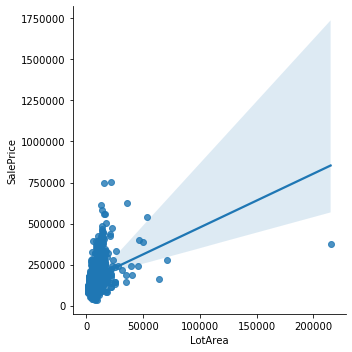

In [46]:
sns.lmplot(x='LotArea',y='SalePrice',data=dbfilter)
#sns.lmplot(x='LotFrontage',y='SalePrice',data=dbfilter)
dbfilter
dbfilter.iloc[:, [0,2]].values

In [631]:
"""
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(grafico['MediaBairro'], method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()
"""
all_data['Cluster'].map(mean_encode).copy()

0       VinylSd
1       Wd Sdng
2       VinylSd
3       Wd Shng
4       VinylSd
         ...   
2914      Other
2915      Other
2916    VinylSd
2917    Wd Shng
2918    Wd Shng
Name: Cluster, Length: 2919, dtype: object

In [629]:
dbfilter = all_data[(~all_data['Exterior2nd'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior2nd','SalePrice']].copy()
dbfilter['media']=all_data['Exterior2nd'].map(dbfilter.groupby(["Exterior2nd"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior2nd')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior2nd'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior2nd'].max().copy()
all_data['Exterior2nd'] = all_data['Cluster'].map(mean_encode).copy()
mean_encode

Cluster
0    Wd Sdng
1    VinylSd
2    Wd Shng
3      Other
Name: Exterior2nd, dtype: object

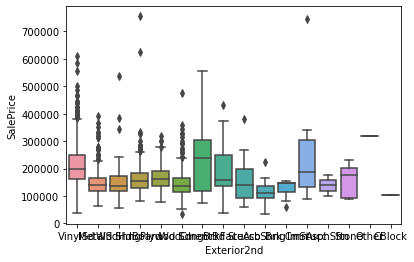

In [536]:
sns.boxplot(x='Exterior2nd',y='SalePrice',data=dbfilter)


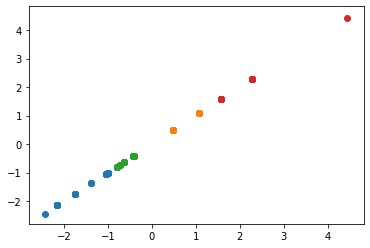

In [636]:
clusters = np.unique(y_hc)
# create scatter plot for samples from each cluster
for cluster in clusters:
    
    # get row indexes for samples with this cluster
    row_ix = np.where(y_hc == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 1], X[row_ix, 1])
# show the plot
plt.show()

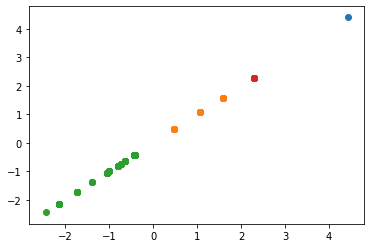

In [494]:
hc = DBSCAN(eps=0.9, min_samples=10)
y_hc=hc.fit_predict(X)
clusters = np.unique(y_hc)
# create scatter plot for samples from each cluster
for cluster in clusters:
    
    # get row indexes for samples with this cluster
    row_ix = np.where(y_hc == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 1], X[row_ix, 1])
# show the plot
plt.show()

In [741]:
for x,y in dbfilter2.groupby(['Cluster','ExterCond']):
    print(x)

(0, 'Ex')
(0, 'Gd')
(0, 'TA')
(1, 'Fa')
(1, 'Po')


In [186]:

all_data["LotFrontage"] = all_data.groupby("ClusterLotArea")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [58]:
y_hc

array([2, 2, 2, 5, 5, 5, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4,
       0, 0, 0], dtype=int64)

In [78]:

source = pd.DataFrame({'Country' : ['USA', 'USA', 'Russia','USA'], 
                  'City' : ['New-York', 'New-York', 'Sankt-Petersburg', 'New-York'],
                  'Short name' : ['NY','New','Spb','NY']})

source.groupby(['Country','City']).agg(lambda x:x.value_counts().index[0])

,,Short name
Country,City,
Russia,Sankt-Petersburg,Spb
USA,New-York,NY


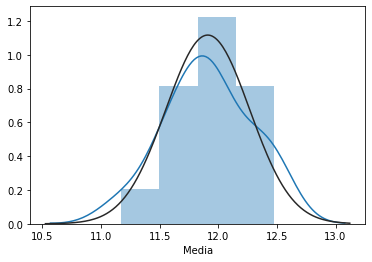

In [406]:

dbfilter2['Media'] = np.log1p(dbfilter2['Media']).copy()
sns.distplot(dbfilter2['Media'] , fit=norm);

In [450]:
all_data['Exterior2nd'].unique()

array(['Wd Shng', 'Other', 'CBlock'], dtype=object)

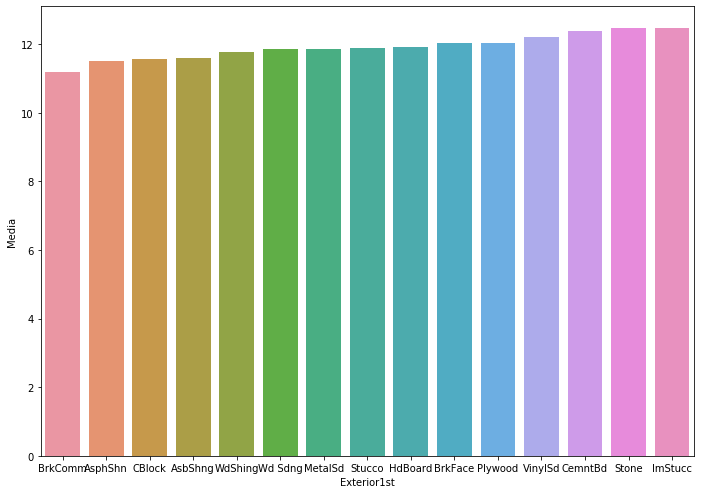

In [410]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax,data=dbfilter2,x='Exterior1st', y='Media')